In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import colorednoise as cn
import qutip as qt
from noise_generator import GenerateNoise
from hamiltonian_generator import Hamiltonian
from system import *
from joblib import Parallel, delayed
from scipy.optimize import curve_fit

In [8]:
class Simulation:
    def __init__(self, A, initial_state, t_max, sample_rate, num_realizations, S0):
        self.A = A
        self.initial_state = initial_state
        
        # System parameters
        self.phi_ex = 0.2
        self.Ej = 30.19 
        self.Ec = 0.1

        # Setup Hamiltonian for optimal frequency calculation
        self.sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [5,3])
        self.optimal_omega,rate = self.sc.optimal_omegad(self.A)
        self.optimal_omega = self.optimal_omega*2*np.pi
        self.sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [3,2]) 
        self.sample_rate = sample_rate
        self.num_realizations = num_realizations
        self.S0 = S0
        self.t_max = t_max
        self.cplus_state, self.kick_and_sigmax, self.get_projector = self.sc.setup_floquet_system(A,self.optimal_omega)
        self.detuning = np.real(self.sc.H)[2,2] - self.optimal_omega

    def noise_check(self, if_plot=False):
        # Initialize arrays to store results
        tnoise_max = int(self.t_max)             # number of samples
        relative_PSD_strength = self.S0**2
        ifwhite = False               # True for white noise, False for 1/f noise
        
        gn = GenerateNoise(self.sample_rate, tnoise_max, relative_PSD_strength, self.num_realizations, ifwhite)
        trajs = gn.generate_colored_noise()
        self.trajs = trajs
        if if_plot:
            gn.analyze_noise_psd(trajs)
    
    def operators(self):
        sds = self.sc.noise
        sop = self.sc.s
        H_control = self.sc.H_control
        H0 = self.sc.H
        diagonal_energies = np.diag(self.sc.H) - self.sc.H[0,0]
        H0 = np.diag(diagonal_energies)
        sds = qt.Qobj(sds)
        sop = qt.Qobj(sop)
        H_control = qt.Qobj(H_control)
        H0 = qt.Qobj(H0)
        return sds, sop, H_control, H0,

    def I_control(self, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        def pulse(t):
            t = np.asarray(t)
            result = np.zeros_like(t, dtype=float)

            # Sin-squared ramp up
            mask1 = (t > 0) & (t < ramp_time)
            result[mask1] = amplitude * np.sin((np.pi / 2) * (t[mask1] / ramp_time))**2

            # Flat top
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            result[mask2] = amplitude

            # Sin-squared ramp down
            mask3 = (t > T - ramp_time) & (t < T)
            result[mask3] = amplitude * np.sin((np.pi / 2) * (1 - (t[mask3] - (T - ramp_time)) / ramp_time))**2

            if result.shape == ():
                return float(result)
            return result

        return pulse

    def Q_control(self, freq, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        peak = amplitude * np.pi / (2 * ramp_time)

        def pulse_derivative(t):
            t = np.asarray(t)
            result = np.zeros_like(t, dtype=float)

            # Derivative of ramp up
            mask1 = (t > 0) & (t < ramp_time)
            result[mask1] = peak * np.sin(np.pi * t[mask1] / ramp_time)

            # Derivative of ramp down
            mask3 = (t > T - ramp_time) & (t < T)
            result[mask3] = -peak * np.sin(np.pi * (t[mask3] - (T - ramp_time)) / ramp_time)

            result = -result / freq

            if result.shape == ():
                return float(result)
            return result

        return pulse_derivative

    import numpy as np

    def A_function(self, freq, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        deriv_peak = amplitude * np.pi / (2 * ramp_time)
        pi_over_2 = np.pi / 2
        pi_over_rt = np.pi / ramp_time
        inv_freq = 1.0 / freq

        def A(t):
            t = np.asarray(t, dtype=float)
            result = np.full_like(t, fill_value=0.0, dtype=float)

            # Use boolean masks once
            mask1 = (t > 0) & (t < ramp_time)
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            mask3 = (t > T - ramp_time) & (t < T)

            # Ramp up calculations
            if np.any(mask1):
                ang1 = pi_over_2 * (t[mask1] / ramp_time)
                sin_ang1 = np.sin(ang1)
                I1 = amplitude * sin_ang1 * sin_ang1
                Q1 = -deriv_peak * np.sin(pi_over_rt * t[mask1]) * inv_freq
                result[mask1] = np.hypot(I1, Q1)  # More efficient for sqrt(I^2+Q^2)

            # Flat top amplitude is constant
            if np.any(mask2):
                result[mask2] = amplitude

            # Ramp down calculations
            if np.any(mask3):
                ang3 = pi_over_2 * (1 - (t[mask3] - (T - ramp_time)) / ramp_time)
                sin_ang3 = np.sin(ang3)
                I3 = amplitude * sin_ang3 * sin_ang3
                Q3 = deriv_peak * np.sin(pi_over_rt * (t[mask3] - (T - ramp_time))) * inv_freq
                result[mask3] = np.hypot(I3, Q3)

            if result.shape == ():
                return float(result)
            return result

        return A


    def phi_function(self, freq, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        deriv_peak = amplitude * np.pi / (2 * ramp_time)
        pi_over_2 = np.pi / 2
        pi_over_rt = np.pi / ramp_time
        inv_freq = 1.0 / freq

        def phi(t):
            t = np.asarray(t, dtype=float)
            result = np.zeros_like(t, dtype=float)

            mask1 = (t > 0) & (t < ramp_time)
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            mask3 = (t > T - ramp_time) & (t < T)

            # Ramp up phase
            if np.any(mask1):
                ang1 = pi_over_2 * (t[mask1] / ramp_time)
                sin_ang1 = np.sin(ang1)
                I1 = amplitude * sin_ang1 * sin_ang1
                Q1 = -deriv_peak * np.sin(pi_over_rt * t[mask1]) * inv_freq
                result[mask1] = np.arctan2(Q1, I1)

            # Plateau phase
            if np.any(mask2):
                result[mask2] = 0.0

            # Ramp down phase
            if np.any(mask3):
                ang3 = pi_over_2 * (1 - (t[mask3] - (T - ramp_time)) / ramp_time)
                sin_ang3 = np.sin(ang3)
                I3 = amplitude * sin_ang3 * sin_ang3
                Q3 = deriv_peak * np.sin(pi_over_rt * (t[mask3] - (T - ramp_time))) * inv_freq
                result[mask3] = np.arctan2(Q3, I3)

            if result.shape == ():
                return float(result)
            return result

        return phi



In [13]:
A = 2.5e-3*2*np.pi
initial_state = []
t_max = 100000
num_realizations = 100
S0 = 1e-5
sample_rate = 1        # per ns
sim = Simulation(A,initial_state, t_max,sample_rate, num_realizations,S0)
sim.noise_check()

In [14]:
sim.detuning/2/np.pi

np.float64(-0.013139255332430948)

In [ ]:
(-0.0073455105936981084)
p.float64(-0.013139255332430948)
(-0.013139255332430948)

In [15]:
# Define parameter ranges
ramp_times = [40, 80, 120, 160, 210]
A_values = [1e-3*2*np.pi, 2.5e-3*2*np.pi, 5e-3*2*np.pi]

def compute_fidelity(ramp_time, A):
    initial_state = []
    t_max = 100000
    num_realizations = 100
    S0 = 1e-5
    sample_rate = 1        # per ns
    sim = Simulation(A,initial_state, t_max,sample_rate, num_realizations,S0)
    sim.noise_check()
    # Setup parameters
    time_points = np.linspace(0, ramp_time, 1000)
    T = 5 * ramp_time
    gamma = 1 / (2e4)

    # Get operators and functions
    sds, sop, H_control, H0 = sim.operators()
    freq = np.abs(np.real(H0.full())[2,2] - sim.optimal_omega)
    A_func = sim.A_function(freq, ramp_time, T, sim.A)
    phi_func = sim.phi_function(freq, ramp_time, T, sim.A)

    # Get Floquet states and projectors
    floquet_states, sigmax, sigmas = sim.kick_and_sigmax(ramp_time)
    projectors = sim.get_projector(floquet_states)

    # Define Hamiltonian terms
    drive_term = lambda t, args: A_func(t) * np.cos(sim.optimal_omega * t + phi_func(t))

    # Solver options and collapse operators
    opts = {'nsteps': sim.t_max, 'atol': 1e-11, 'rtol': 1e-11}
    c_ops = [np.sqrt(gamma) * qt.Qobj(sop)]

    # Run simulations for both initial states
    avg_values = []
    for idx in [0, 1]:
        def run_single_trajectory(traj_idx):
            traj = np.cos(sim.phi_ex*np.pi)*(np.cos(sim.trajs[traj_idx]*np.pi)-1) - np.sin(sim.phi_ex*np.pi)*np.sin(sim.trajs[traj_idx]*np.pi)
            noise_term = lambda t, args: traj[int(t * sim.sample_rate)] if t < sim.t_max else 0
            H = [H0, [sds, noise_term], [H_control, drive_term]]
            result = qt.mesolve(H, qt.basis(6, idx), time_points, c_ops, options=opts)
            return result.states[-1]
        
        # Parallelize over all trajectories using joblib
        from joblib import Parallel, delayed
        final_states = Parallel(n_jobs=-1)(delayed(run_single_trajectory)(traj_idx) for traj_idx in range(sim.num_realizations))
        
        # Compute average final state
        final_state = sum(final_states) / len(final_states)
        
        avg_values.append(qt.expect(projectors[idx], final_state))

    avg_value0, avg_value1 = avg_values
    return (np.sqrt(avg_value0) + np.sqrt(avg_value1))**2/4

# Run for loop for different ramp_time and A values
results = []
for ramp_time in ramp_times:
    for A in A_values:
        fidelity = compute_fidelity(ramp_time, A)
        results.append(fidelity)
        print(f"Ramp time: {ramp_time}, A: {A/(2*np.pi):.3e}, Fidelity: {fidelity}")

# Create fidelity matrix
fidelity_matrix = np.array(results).reshape(len(ramp_times), len(A_values))

print(f"\nRamp times: {ramp_times}")
print(f"A values: {[A/(2*np.pi) for A in A_values]}")
print(f"Fidelity matrix shape: {fidelity_matrix.shape}")
print(f"Fidelity matrix:\n{fidelity_matrix}")

Ramp time: 40, A: 1.000e-03, Fidelity: 0.9993765799992083
Ramp time: 40, A: 2.500e-03, Fidelity: 0.999648305488897
Ramp time: 40, A: 5.000e-03, Fidelity: 0.9997707262398448
Ramp time: 80, A: 1.000e-03, Fidelity: 0.9996301359814009
Ramp time: 80, A: 2.500e-03, Fidelity: 0.9999104012908449
Ramp time: 80, A: 5.000e-03, Fidelity: 0.9999386975213668
Ramp time: 120, A: 1.000e-03, Fidelity: 0.99984599637028
Ramp time: 120, A: 2.500e-03, Fidelity: 0.9999293682326904
Ramp time: 120, A: 5.000e-03, Fidelity: 0.9999349822733856
Ramp time: 160, A: 1.000e-03, Fidelity: 0.999891099675609
Ramp time: 160, A: 2.500e-03, Fidelity: 0.9999212206004681
Ramp time: 160, A: 5.000e-03, Fidelity: 0.999922735899765
Ramp time: 210, A: 1.000e-03, Fidelity: 0.9998969767493595
Ramp time: 210, A: 2.500e-03, Fidelity: 0.9998963678419416
Ramp time: 210, A: 5.000e-03, Fidelity: 0.9999039210034164

Ramp times: [40, 80, 120, 160, 210]
A values: [0.001, 0.0025, 0.005]
Fidelity matrix shape: (5, 3)
Fidelity matrix:
[[0.99937

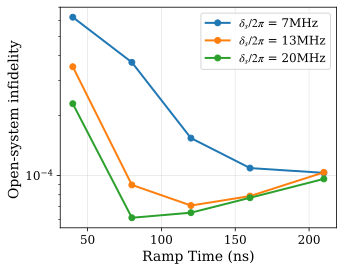

In [27]:
# Create a figure for plotting 1-fidelity vs ramp_time for different A values
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# Set font sizes for paper-quality figure
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times', 'DejaVu Serif'],
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 14,
    'mathtext.fontset': 'stix'
})
sfreq_mhz = [7,13,20]
# Plot 1-fidelity for each A value
for i, A in enumerate(A_values):
    infidelity = 1 - fidelity_matrix[:, i]
    ax.plot(ramp_times, infidelity, 'o-', label=f'$\\delta_s/2\\pi$ = {freq_mhz[i]:.0f}MHz', linewidth=2, markersize=6)

ax.set_xlabel('Ramp Time (ns)')
ax.set_ylabel('Open-system infidelity ')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
# Save the plot in tight form as a PDF with the name 'preparation_fidelity.pdf'
plt.savefig('preparation_fidelity.pdf', bbox_inches='tight')
plt.show()

Fidelity matrix (rows: ramp_times, columns: A_values):
Ramp times: [30, 80, 120, 160, 210]
A values: [1.0, 2.5, 5.0] (in units of 1e-3*2π)
[[0.99933782 0.99956588 0.99962878]
 [0.99969652 0.99994811 0.99996619]
 [0.99990406 0.99996377 0.99996838]
 [0.99995741 0.99995997 0.9999586 ]
 [0.99994458 0.99994772 0.99994587]]


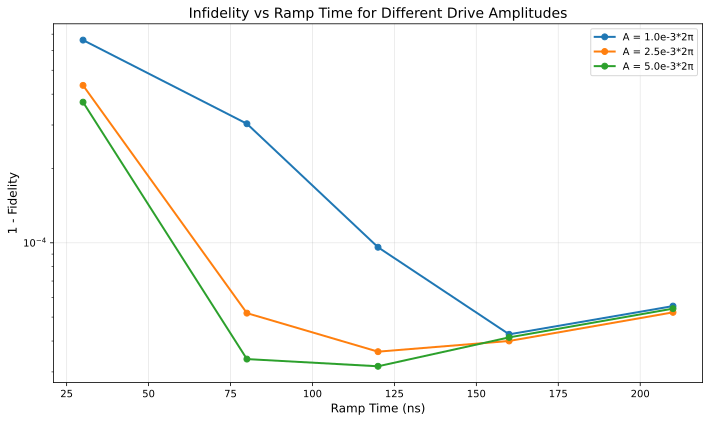

Ramp time: 30, A: 1.0e-3*2π, Fidelity: 0.999338, Infidelity: 0.000662
Ramp time: 30, A: 2.5e-3*2π, Fidelity: 0.999566, Infidelity: 0.000434
Ramp time: 30, A: 5.0e-3*2π, Fidelity: 0.999629, Infidelity: 0.000371
Ramp time: 80, A: 1.0e-3*2π, Fidelity: 0.999697, Infidelity: 0.000303
Ramp time: 80, A: 2.5e-3*2π, Fidelity: 0.999948, Infidelity: 0.000052
Ramp time: 80, A: 5.0e-3*2π, Fidelity: 0.999966, Infidelity: 0.000034
Ramp time: 120, A: 1.0e-3*2π, Fidelity: 0.999904, Infidelity: 0.000096
Ramp time: 120, A: 2.5e-3*2π, Fidelity: 0.999964, Infidelity: 0.000036
Ramp time: 120, A: 5.0e-3*2π, Fidelity: 0.999968, Infidelity: 0.000032
Ramp time: 160, A: 1.0e-3*2π, Fidelity: 0.999957, Infidelity: 0.000043
Ramp time: 160, A: 2.5e-3*2π, Fidelity: 0.999960, Infidelity: 0.000040
Ramp time: 160, A: 5.0e-3*2π, Fidelity: 0.999959, Infidelity: 0.000041
Ramp time: 210, A: 1.0e-3*2π, Fidelity: 0.999945, Infidelity: 0.000055
Ramp time: 210, A: 2.5e-3*2π, Fidelity: 0.999948, Infidelity: 0.000052
Ramp time: 2

In [10]:
def compute_fidelity(ramp_time, A):
    initial_state = []
    t_max = 100000
    num_realizations = 100
    S0 = 1e-5
    sample_rate = 1        # per ns
    sim = Simulation(A,initial_state, t_max,sample_rate, num_realizations,S0)
    sim.noise_check()
    # Setup parameters
    time_points = np.linspace(0, ramp_time, 1000)
    T = 5 * ramp_time
    gamma = 1 / (2e4)

    # Get operators and functions
    sds, sop, H_control, H0 = sim.operators()
    freq = np.abs(np.real(H0.full())[2,2] - sim.optimal_omega)
    A_func = sim.A_function(freq, ramp_time, T, sim.A)
    phi_func = sim.phi_function(freq, ramp_time, T, sim.A)

    # Get Floquet states and projectors
    floquet_states, sigmax, sigmas = sim.kick_and_sigmax(ramp_time)
    projectors = sim.get_projector(floquet_states)

    # Define Hamiltonian terms
    drive_term = lambda t, args: A_func(t) * np.cos(sim.optimal_omega * t + phi_func(t))

    # Solver options and collapse operators
    opts = {'nsteps': sim.t_max, 'atol': 1e-11, 'rtol': 1e-11}
    c_ops = [np.sqrt(gamma) * qt.Qobj(sop)]

    # Run simulations for both initial states
    avg_values = []
    for idx in [0, 1]:
        H = [H0, [H_control, drive_term]]
        result = qt.mesolve(H, qt.basis(6, idx), time_points, c_ops, options=opts)
        final_state = result.states[-1]    
        avg_values.append(qt.expect(projectors[idx], final_state))
    avg_value0, avg_value1 = avg_values
    return (np.sqrt(avg_value0) + np.sqrt(avg_value1))**2/4

# Define parameter ranges
ramp_times = [40, 80, 120, 160, 210]
A_values = [1e-3*2*np.pi, 2.5e-3*2*np.pi, 5e-3*2*np.pi]

# Create parameter combinations
from itertools import product
param_combinations = list(product(ramp_times, A_values))

# Parallelize over all parameter combinations using joblib
from joblib import Parallel, delayed
results = Parallel(n_jobs=-1)(delayed(compute_fidelity)(ramp_time, A) for ramp_time, A in param_combinations)

# Organize results
fidelity_matrix = np.array(results).reshape(len(ramp_times), len(A_values))

# Print results
print("Fidelity matrix (rows: ramp_times, columns: A_values):")
print(f"Ramp times: {ramp_times}")
print(f"A values: {[A/(2*np.pi*1e-3) for A in A_values]} (in units of 1e-3*2π)")
print(fidelity_matrix)

# Plot 1-fidelity vs ramp time for different A values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, A in enumerate(A_values):
    infidelities = 1 - fidelity_matrix[:, i]
    A_label = f'A = {A/(2*np.pi*1e-3):.1f}e-3*2π'
    plt.plot(ramp_times, infidelities, 'o-', label=A_label, linewidth=2, markersize=6)

plt.xlabel('Ramp Time (ns)', fontsize=12)
plt.ylabel('1 - Fidelity', fontsize=12)
plt.title('Infidelity vs Ramp Time for Different Drive Amplitudes', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

# Print individual results
for i, (ramp_time, A) in enumerate(param_combinations):
    print(f"Ramp time: {ramp_time}, A: {A/(2*np.pi*1e-3):.1f}e-3*2π, Fidelity: {results[i]:.6f}, Infidelity: {1-results[i]:.6f}")